In [7]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
               
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import stats

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
import time_of_emrgence_calc as toe

In [9]:
from dask.distributed import Client
client = Client()
client

- State start
-   Scheduler at:     tcp://127.0.0.1:36797
-   dashboard at:         /proxy/8787/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:33525'
-         Start Nanny at: 'tcp://127.0.0.1:46725'
-         Start Nanny at: 'tcp://127.0.0.1:44691'
-         Start Nanny at: 'tcp://127.0.0.1:45433'
-         Start Nanny at: 'tcp://127.0.0.1:38329'
-         Start Nanny at: 'tcp://127.0.0.1:44299'
-         Start Nanny at: 'tcp://127.0.0.1:38821'
- Register worker <WorkerState 'tcp://127.0.0.1:46463', name: 5, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:46463
- Starting established connection to tcp://127.0.0.1:43216
- Register worker <WorkerState 'tcp://127.0.0.1:43929', name: 4, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:43929
- Starting established connection to tcp://127.0.0.1:43198
- Register worker <WorkerState 'tcp://127.0.0.1:39031', name: 2, status

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36797,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:38251,Total threads: 4
Dashboard: /proxy/38311/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:33525,


In [10]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

# Opening Best

In [11]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [12]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon'})

best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))

0.3.0


In [13]:
best_ds = best_ds.resample(time='Y').mean()

In [14]:
# Only 43MB - load into memory
best_ds = best_ds.compute()

In [15]:
best_ds

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360)>
nan nan nan nan nan nan nan nan ... 2.237 2.238 2.24 2.241 2.242 2.243 2.244
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

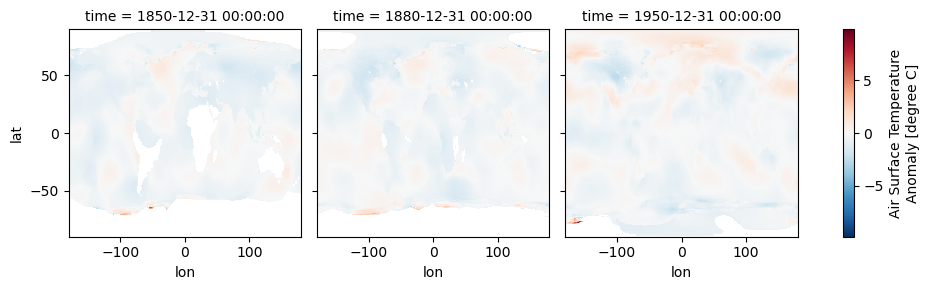

In [16]:
best_ds.isel(time=[0, 30, 100]).plot(col='time')

In [17]:
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
nan nan nan nan nan nan ... -0.027 -0.02725 -0.02678 -0.02644 -0.02708 -0.02708
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

# Calculations

In [18]:
window = 20

## Signal-to-Noise

### Trend Fit

In [12]:
base_period_mean_ds = base_period_ds.mean(dim='time')

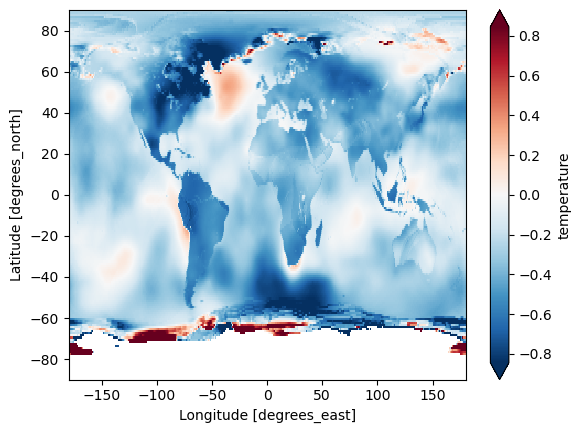

In [13]:
base_period_mean_ds.plot(robust=True)

In [14]:
best_ds_no_baseperiod = best_ds.sel(time=best_ds.time.dt.year>start_end_tuple[-1])
best_ds_no_baseperiod

<xarray.DataArray 'temperature' (time: 124, lat: 180, lon: 360)>
nan nan nan nan nan nan nan nan ... 2.237 2.238 2.24 2.241 2.242 2.243 2.244
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1901-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

In [15]:
ds_best_poly = stats.trend_fit(best_ds_no_baseperiod, method='POLYNOMIAL', order=4)#'LOWESS', lowess_window=40)

In [16]:
ds_best_detrend_poly = best_ds_no_baseperiod - ds_best_poly

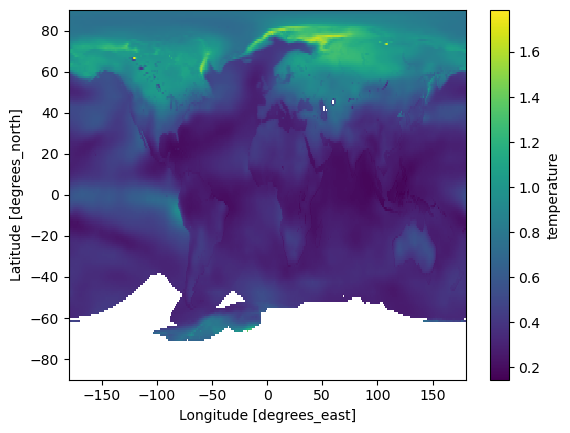

In [17]:
ds_best_detrend_poly.std(dim=['time']).plot()

### Noise Calculation

In [18]:
noise_ds = base_period_ds.std(dim='time')

In [19]:
# noise_ds = sn.noise(ds_best_detrend_poly)

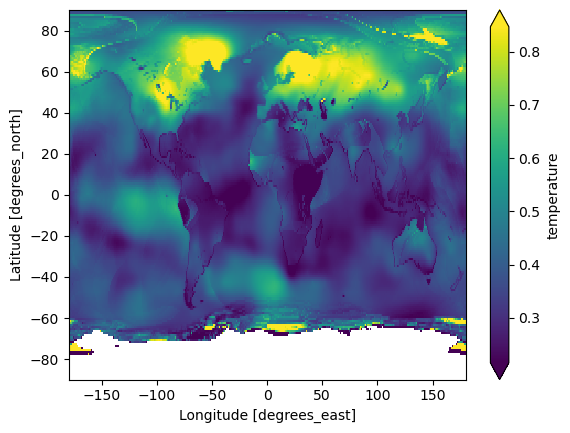

In [20]:
noise_ds.plot(robust=True)

### Baseline

In [21]:
rolling_mean_ds = best_ds.rolling(time=window, center=False).mean()
rolling_mean_ds = sn.adjust_time_from_rolling(rolling_mean_ds, window)
rolling_mean_ds

<xarray.DataArray 'temperature' (time: 155, lat: 180, lon: 360)>
nan nan nan nan nan nan nan nan ... 1.598 1.599 1.598 1.598 1.598 1.597 1.597
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2004-12-31 00:00:00
Attributes: (5)

In [22]:
rolling_mean_ds = rolling_mean_ds.sel(time=rolling_mean_ds.time.dt.year>1900)

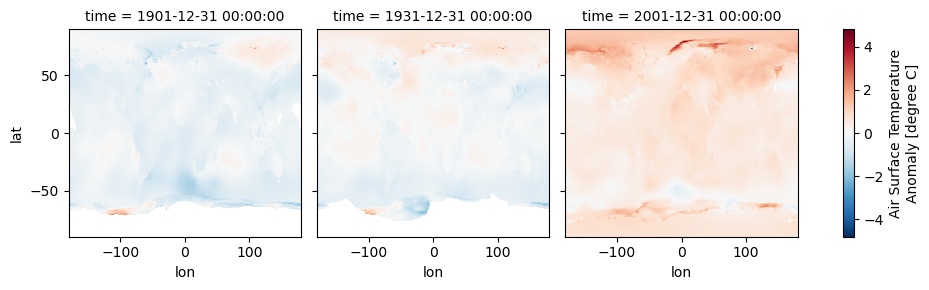

In [23]:
rolling_mean_ds.isel(time=[0, 30, 100]).plot(col='time')

In [24]:
baseline_signal_ds = rolling_mean_ds - base_period_mean_ds
baseline_signal_ds

<xarray.DataArray 'temperature' (time: 104, lat: 180, lon: 360)>
nan nan nan nan nan nan nan nan ... 1.853 1.852 1.846 1.846 1.846 1.847 1.847
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1901-12-31 00:00:00 ... 2004-12-31 00:00:00

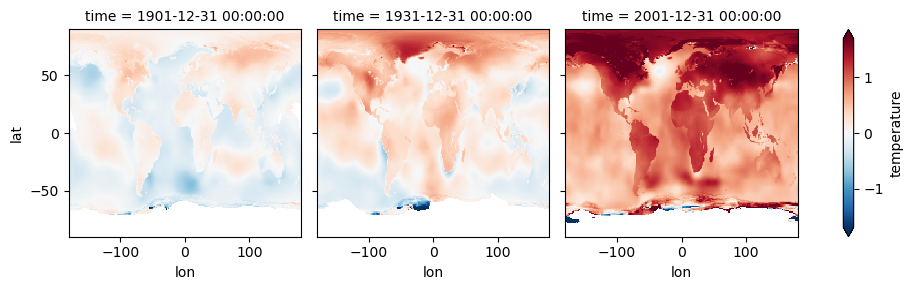

In [25]:
baseline_signal_ds.isel(time=[0, 30, 100]).plot(col='time', robust=True)

In [26]:
baseline_sn_ds = baseline_signal_ds/noise_ds
baseline_sn_ds

<xarray.DataArray 'temperature' (time: 104, lat: 180, lon: 360)>
nan nan nan nan nan nan nan nan ... 5.18 5.179 5.121 5.119 5.118 5.118 5.118
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1901-12-31 00:00:00 ... 2004-12-31 00:00:00

### Polynomial Signal

In [27]:
ds_best_signal_poly = ds_best_poly - base_period_mean_ds

In [28]:
ds_best_sn_poly = ds_best_signal_poly/noise_ds

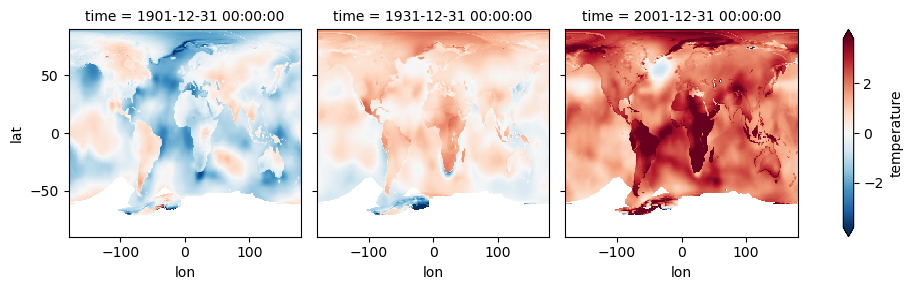

In [29]:
ds_best_sn_poly.isel(time=[0, 30, 100]).plot(col='time', robust=True)

## KS-test

In [19]:
local_ks_ds = toe.apply_kstest_along_array(best_ds, window)

In [35]:
from scipy.stats import kstest

In [36]:
def return_kstest_pvalue(test_arr,base_arr):
    return kstest(test_arr.data, base_arr.data).pvalue

In [42]:
%%time
local_ks_ds=xr.apply_ufunc(
        return_kstest_pvalue,
        best_ds.rolling(time=window).construct('window_dim')[(window-1):],
        base_period_ds.rename({'time':'window_dim'}),
        input_core_dims=[['window_dim'],['window_dim'],],
        exclude_dims=set(('window_dim',)),
        vectorize=True,
        dask='parallelized'
)

CPU times: user 22min 22s, sys: 59.7 s, total: 23min 22s
Wall time: 22min 20s


### No Ufunc

In [43]:
def kstest_with_base(arr, window):
    # The data to use for the base period
    base_period_length = 50
    base_list = arr[:base_period_length]
    # Fill funcion with base data
    kstest_partial = partial(kstest, base_list)
    # Stop when there is not enogu points left
    number_itterations = arr.shape[0] - window
    kstest_array = np.zeros(number_itterations)
    for t in np.arange(number_itterations):
        arr_subset = arr[t:t+window]
        ks_value = kstest_partial(arr_subset).pvalue
        kstest_array[t] = ks_value
    return kstest_array

In [44]:
kstest_with_base = partial(kstest_with_base, window=window)

In [ ]:
# Dropped this for now. Need to have a shorter time, need to figure out how to add this in
# xr.apply_ufunc(
#     kstest_with_base,
#     best_ds.sel(lat=slice(-40, -20), lon=slice(110, 150)),
#     input_core_dims
    
# )

In [73]:
%%time
local_ks_np = np.apply_along_axis(
    kstest_with_base, 
    best_ds.get_axis_num('time'), 
    best_ds.to_numpy())


KeyboardInterrupt



In [74]:
time_axis_num = best_ds.get_axis_num('time')
local_ks_ds = xr.zeros_like(best_ds.isel(time=slice(0, local_ks_np.shape[time_axis_num])))

NameError: name 'local_ks_np' is not defined

In [ ]:
local_ks_np.shape

In [ ]:
local_ks_ds.shape

In [ ]:
local_ks_ds += local_ks_np

In [ ]:
local_ks_ds.isel(time=[0, 30, 100]).plot(col='time')

### KS-test Method Comparison

In [47]:
test_subset = best_ds.sel(lat=slice(-40, -20), lon=slice(110, 150))
test_subset

<xarray.DataArray 'temperature' (time: 175, lat: 20, lon: 40)>
-0.2327 -0.241 -0.2375 -0.2063 -0.1995 -0.1623 ... 1.223 1.301 1.397 1.423 1.323
Coordinates:
  * lat      (lat) float32 -39.5 -38.5 -37.5 -36.5 ... -23.5 -22.5 -21.5 -20.5
  * lon      (lon) float32 110.5 111.5 112.5 113.5 ... 146.5 147.5 148.5 149.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (5)

In [49]:
%%time
_= np.apply_along_axis(
    kstest_with_base, 
    test_subset.get_axis_num('time'), 
    test_subset.to_numpy())

CPU times: user 12.4 s, sys: 178 ms, total: 12.6 s
Wall time: 12.4 s


In [51]:
%%time
_=xr.apply_ufunc(
        return_kstest_pvalue,
        test_subset.rolling(time=window).construct('window_dim')[(window-1):],
        base_period_ds.sel(lat=slice(-40, -20), lon=slice(110, 150)).rename({'time':'window_dim'}),
        input_core_dims=[['window_dim'],['window_dim'],],
        exclude_dims=set(('window_dim',)),
        vectorize=True,
        dask='parallelized'
)

CPU times: user 13.8 s, sys: 160 ms, total: 14 s
Wall time: 13.8 s


In [52]:
kstest_base_for_lambda = partial(kstest, base_period_ds.to_numpy())
def return_kstest_pvalue_for_lambda(arr):
    return kstest_base_for_lambda(arr).pvalue

# Getting ToE

In [54]:
# def get_exceedance_arg(arr, time, threshold, comparison_func):

#     # Entire nan slice, return nan
#     if all(np.isnan(arr)): return np.nan
        
#     greater_than_arg_list = comparison_func(arr, threshold)

#     # No value exceed threshold - return nan
#     if np.all(greater_than_arg_list == False): return np.nan

#     # The first exceedance of the threshold
#     first_exceedance = time[greater_than_arg_list][0]
    
    # return first_exceedance

In [55]:
def get_exceedance_arg(arr, time, threshold, comparison_func):
    '''

    Example
    data = [False, False, False, False, False, False,
    False, False, False, False, True, False, True, 
    True, True]

    # Group consecutive True and False values
    groups = [(key, len(list(group))) for key, group in groupby(data)]
    
    groups[-1][0] == True
    
    np.sum(list(map(lambda x: x[1], groups))[:-1])
    '''

    # Entire nan slice, return nan
    if all(np.isnan(arr)): return np.nan
        
    greater_than_arg_list = comparison_func(arr, threshold)

    # No value exceed threshold - return nan
    if np.all(greater_than_arg_list == False): return np.nan

    # Group consecutive True and False values
    groups = [(key, len(list(group))) for key, group in groupby(greater_than_arg_list)]

    # If the last group is false, this means that there is not different at the end
    if groups[-1][0] == False: return np.nan
        
    #Otherwise the last group is True
    
    # The arguemnt will be the sum of all the other group lengths up to to the last group
    first_exceedance_arg = int(np.sum(list(map(lambda x: x[1], groups))[:-1]))

    # Thus, we can get the time
    first_exceedance = time[first_exceedance_arg]
    
    return first_exceedance

In [56]:
exceedence_dict = dict(
    input_core_dims=[['time']],
    output_core_dims=[[]],
    vectorize=True, 
    dask='parallelized',
    output_dtypes=[float])

## Signal-to-Noise

In [57]:
get_exceedance_arg_partial_sn = partial(get_exceedance_arg, time=ds_best_sn_poly.time.dt.year.values, threshold=2, comparison_func=np.greater)

In [58]:
sn_toe_ds = xr.apply_ufunc(
    get_exceedance_arg_partial_sn, 
    ds_best_sn_poly, 
    **exceedence_dict
)

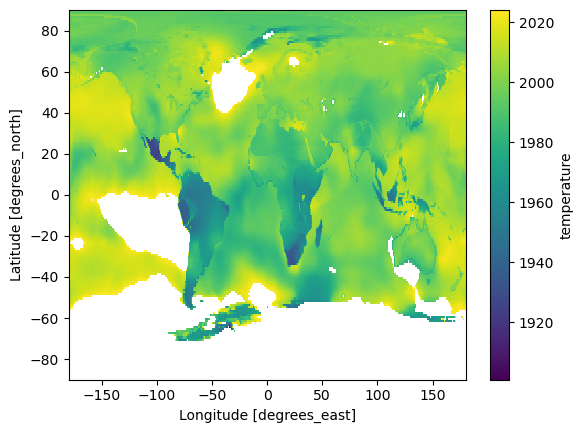

In [59]:
sn_toe_ds.plot()

## KS Test

In [60]:
baseline_sn_ds

<xarray.DataArray 'temperature' (time: 104, lat: 180, lon: 360)>
nan nan nan nan nan nan nan nan ... 5.18 5.179 5.121 5.119 5.118 5.118 5.118
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1901-12-31 00:00:00 ... 2004-12-31 00:00:00

In [61]:
local_ks_subset_ds = local_ks_ds.sel(time=local_ks_ds.time.dt.year>1900)
local_ks_subset_ds

<xarray.DataArray 'temperature' (time: 124, lat: 180, lon: 360)>
1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0001247 0.0001247 0.0001247 0.0001247 0.0001247
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1901-12-31 00:00:00 ... 2024-12-31 00:00:00

In [62]:
get_exceedance_arg_partial_ks = partial(get_exceedance_arg, time=local_ks_subset_ds.time.dt.year.values, threshold=0.01, comparison_func=np.less)

In [63]:
ks_toe_ds = xr.apply_ufunc(
    get_exceedance_arg_partial_ks, 
    local_ks_subset_ds, 
    **exceedence_dict
)

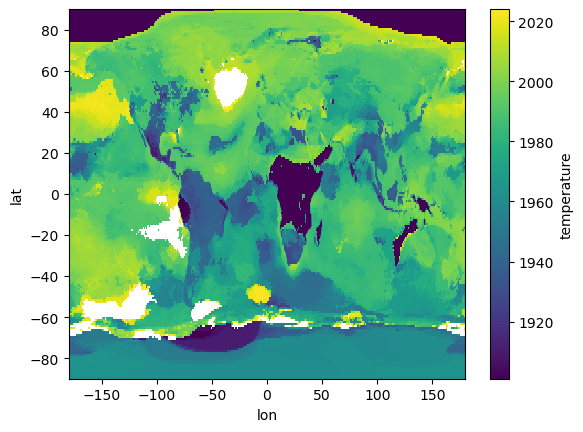

In [64]:
ks_toe_ds.plot()

## Comparison

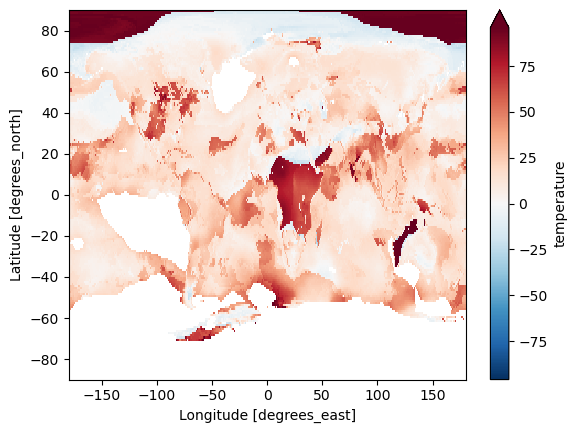

In [65]:
(sn_toe_ds - ks_toe_ds).plot(robust=True)

Text(0.5, 1.0, 'Difference (SN - KS)')

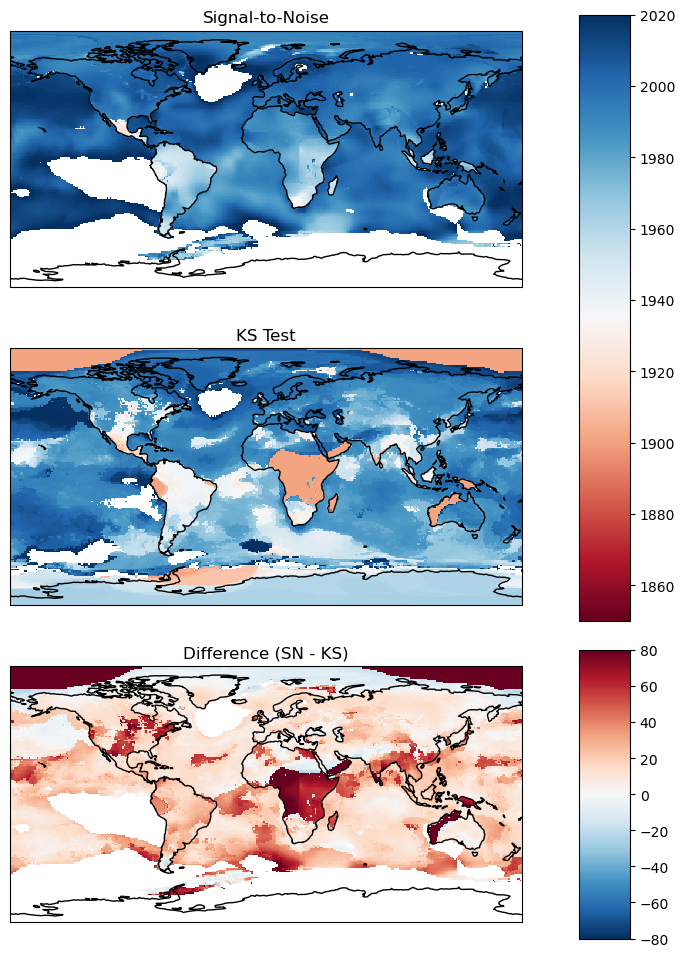

In [70]:
fig = plt.figure(figsize=(8, 12))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(3)]

toe_plot_kwargs = dict(cmap='RdBu',add_colorbar=False, vmin=1850, vmax=2020)

sn_toe_ds.plot(ax=axes[0], **toe_plot_kwargs)
toe_plot = ks_toe_ds.plot(ax=axes[1], **toe_plot_kwargs)

cbar_axes1 = plt.subplot(gs[:2, 1])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')

diff_plot = (sn_toe_ds - ks_toe_ds).plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[2, 1])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='vertical')

for ax in axes: ax.coastlines()

axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

Text(0.5, 1.0, 'Difference (SN - KS)')

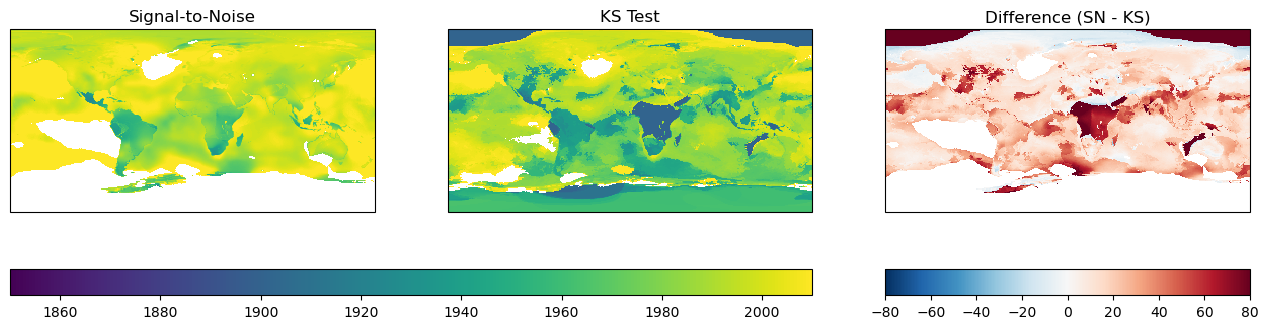

In [67]:
fig = plt.figure(figsize=(16, 4))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(2, 3, height_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[0, i], projection=projection) for i in range(3)]

sn_toe_ds.plot(ax=axes[0], add_colorbar=False, vmin=1850, vmax=2010)
toe_plot = ks_toe_ds.plot(ax=axes[1], add_colorbar=False, vmin=1850, vmax=2010)

cbar_axes1 = plt.subplot(gs[1, :2])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

diff_plot = (sn_toe_ds - ks_toe_ds).plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[1, 2])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='horizontal')


axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')